** Import Libraries **

In [1]:
## Import libraries

import os, glob, pandas as pd
import string, re
import numpy as np
from tqdm import tqdm
from collections import Counter
import numbers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from string import ascii_lowercase
import os 
import glob
import re
import requests
import shutil
import pandas as pd
import time
from nltk import ngrams
from operator import itemgetter

** Input Raw Data & HISCO list **

In [2]:
# Import Raw Data (.csv file with harvested advertisements (using the KB-harvesting script))

os.chdir("C://Users//Ruben//Downloads//metadata//leco_set_80")
df = pd.read_csv('1880-1890.csv', sep = '\t')

#df = df.sample(n=2000)
#df = df.reset_index(drop=True)

In [3]:
# Import HISCO list
os.chdir("C://Users//Ruben//Documents//GitHub//dhl-ads//resources")
with open('list_occ_total.txt', encoding = 'utf-8') as f:
    list_words = f.read().splitlines()

list_words = list(set(list_words))
list_words = list_words + ['loopjongen']
list_words = set(list_words)

# Import QUAL Indicator list
os.chdir("C://Users//Ruben//Documents//GitHub//dhl-ads//resources")
with open('qualitative_indicators.txt', encoding = 'utf-8') as f:
    qual_words = f.read().splitlines()
    
# Import QUAL Indicator list
os.chdir("C://Users//Ruben//Documents//GitHub//dhl-ads//resources")
with open('wage_indicators.txt', encoding = 'utf-8') as f:
    wage_words = f.read().splitlines()

** Define Cleaning and Other Useful Functions **

In [4]:
## Set cleaning (or tokenizing) function
## This function removes punctuation using string + regex and splits sentences on spaces

def clean_and_split_str(txt):
    #strip_special_chars = re.compile("[^A-Za-z0-9#]+")
    translator = str.maketrans('', '', string.punctuation)
    txt = txt.translate(translator)
    txt = re.sub('\s+', ' ', txt).strip()
    txt = txt.lower()
    txt = txt.split(' ')
    return txt

## Function to detect whether a string contains a number

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

** Data Tokenizing **

In [5]:
df['clean'] = [clean_and_split_str(i) for i in df.ocr]
#df['clean'] = [i for i in df.ocr]

** Line Extraction **

The loop below searches for occupations in the cleaned articles. A list is used that includes the HISCO occupation and OCR-'alternatives' aquired through word embeddings and string distance measuring. Once an occupation is identified, a region 'around' it (L12:R40) is selected. This window is chosen because it seems to yield the most occupation-wage combinations. Larger windows to the right can be considered.

Two choices in this step influence the outcome

- the window. Lots of close reading more or less shows that the occupation - wage combi is found relatively close together, allowing for a relatively small window (< 50 to the right).

- the word 'loon'. If this word is not in the extracted window or 'slice', the window is not included. Again, reading through lots of advertisements justifies this choice, because practically all the job advertisements contains the word 'loon'. 

In [6]:
alphabet_id = [c for c in ascii_lowercase] + [c + c for c in ascii_lowercase] + [c + c +c for c in ascii_lowercase]

In [7]:
opd = dict()
ctr = 0 # counter for showing progress

for c,i in enumerate(df.clean):
    
    ctr += 1
    
    if any(e in i for e in list_words):     # check if there is an occupation in the advertisement
        
        occ_list = list()
        
        list_set_ad = set(i)
        list_occupations = set(list_words)
        
        occ_list = occ_list + list(list_occupations.intersection(list_set_ad))  # loop over every word and check if it is an occupation 
                
        
        for count,o in enumerate(occ_list):                       # loop over occupations in ad-occupation list and select windows around 'em
            ind = i.index(o)
            sl = i[ind-12:ind+40]
            sl = ' '.join(sl)
            if 'loon ' in sl or 'salaris' in sl:               # if the word 'loon' is in the window; append [occupation:window] to list (not dictionary because of duplicate occupations)
                output_list = [o, sl, df['id'][c], df['date'][c], df['image_url'][c], i, ind]   
                opd.update({str(c) + alphabet_id[count]:output_list})
    
    if ctr % 5000 == 0:                    # print the progress
        print(str(round(ctr / len(df.clean) * 100)) + "%")

5%
11%
16%
22%
27%
32%
38%
43%
48%
54%
59%
65%
70%
75%
81%
86%
91%
97%


In [8]:
## Convert output dictionary to dataframe (for clarity)
dfa = pd.DataFrame([opd.keys() ,[v[3] for k,v in opd.items()], [v[0] for k,v in opd.items()], [v[1] for k,v in opd.items()],[v[4] for k,v in opd.items()], [' '.join(v[5]) for k,v in opd.items()],[v[6] for k,v in opd.items()],]).T
dfa.columns = ['id','date', 'oc', 'window','image_url', 'ocr', 'occ_index']

** Set Wage Extraction Function **

In the function below, we specify how wages should be extracted. The function requires a string input (the windows extracted in the previous step). 

In [60]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

## Check Qualitative Indcators
def ExtractQual(string):
    s= string.split(' ')
    loon = 'na'

    list_qualitative_wage_indicators=qual_words

    s_unigrams = s
    s_bigrams = ["_".join(list(i)) for i in ngrams(s, 2)]

    uni_bi= s_unigrams + s_bigrams

    if any(x in uni_bi for x in list_qualitative_wage_indicators):

        qualitative_wage = list([i for i in uni_bi if i in list_qualitative_wage_indicators])

        if len(qualitative_wage) > 0:
            loon = [loon for loon in list(set(qualitative_wage))]
            return loon

    else:
        loon = 'na'
        return loon

## Extract Numbers
def GetNum(string):
    s = string.split(' ')
    all_numbers = []

    for i,w in enumerate(s):
        if hasNumbers(w) == True or w in wage_words:
            all_numbers.append([i, w])
    return all_numbers

## Classify Numbers
def NumberCandidateClass(string, index, number_candidate):
    string = string.split(' ')
    ## Set Variables
    score = 0
    weights = 0
    features = []
    len_string = len(string) - 1

    # Negative
    if len(number_candidate) > 5:
        score += -1
        weights += 1
    if number_candidate[0:2] == "18" and len(number_candidate) == 4:
        score += -1
        weights += 1
    try:
        if string[index+1] in ['januari', 'februari', 'maart', 'april', 'mei', 'juni', 'juli', 'augustus', 'september', 'oktober', 'november', 'december']:
            score += -1
            weights += 1
    except IndexError:
        pass

    if string[index-1] == "f" or string[index-1] == 'ƒ':
        score += 1
        weights += 1
    if number_candidate[0] == "f" or number_candidate[0] == 'ƒ':
        score += 1
        weights += 1
    if string[index-1] == "van":
        score += 1
        weights += 1

    try:
        if string[index+1] == "gulden" or string[index+2] == "gulden":
            score += 1
            weights += 1
    except IndexError:
        pass

    if string[index-1] in ['loon', 'salaris','beloning','jaarwedde'] or string[index-2] in ['loon', 'salaris','beloning','jaarwedde']:
        score += 1
        weights += 1

    if string[index-1] == "tegen":
        score += 1
        weights += 1

    try:
        if string[index+1] in ['loon', 'salaris','beloning','jaarwedde'] or string[index+2] in ['loon', 'salaris','beloning','jaarwedde']:
            score += 2
            weights += 1
    except IndexError:
        pass

    #print(features)
    return score

def ExtractNum(string):
    list_numbers = GetNum(string)
    list_scores = list(zip([number for ind,number in list_numbers], [NumberCandidateClass(string, ind, number) for ind, number in list_numbers]))
    if len(list_scores) > 0 and max([score for loon,score in list_scores]) > 0:
        winning_number = max([score for loon,score in list_scores])
        loon =  [loon for loon,score in list_scores if score == winning_number][0]
    else:
        loon = "na"
    return loon

## Detect Non-Numerical
def NonNumbClass(string):
    s = string.split(' ')
    candidates = []

    f_instances = [w for w in s if "ƒ" in w and hasNumbers(w) == False]

    for f in f_instances:

        if len(f) > 1 and f[0] == 'ƒ':
            candidates.append(f)
        
        if len(f) == 1:
            f_index = s.index(f)
            
            try:
                if "o" in s[f_index + 1]:
                        candidates.append(" ".join(s[f_index:f_index + 1]))
            except IndexError:
                pass
    if len(candidates) == 0:
        candidates = "na"
        return candidates
    else:
        return candidates[0]


In [86]:
dfa['ex_qual'] = ""
dfa['ex_num'] = ""
dfa['ex_nonnum'] = ""

for i in range(len(dfa)):
 
    dfa['ex_qual'][i] = ExtractQual(dfa['window'][i])
    dfa['ex_num'][i] = ExtractNum(dfa['window'][i])
    dfa['ex_nonnum'][i] = NonNumbClass(dfa['window'][i])

In [87]:
dfa['ex_qual_id'] = ""
dfa['ex_num_id'] = ""
dfa['ex_nonnum_id'] = ""

for i in range(len(dfa)):
    
    window = dfa['window'][i]
    
    if dfa['ex_qual'][i] != "na":
        new_list = []
        for q in dfa['ex_qual'][i]:
            ind = window.index(q.replace("_"," "))
            new_list.append(q + "_" + str(ind))
        dfa['ex_qual_id'][i] = " ".join(new_list)
        
    if dfa['ex_num'][i] != "na":
        ind = window.index(dfa['ex_num'][i])
        dfa['ex_num_id'][i] = dfa['ex_num'][i] + "_" + str(ind)
    
    if dfa['ex_nonnum'][i] != "na":
        new_list = []
        for q in dfa['ex_nonnum'][i]:
            ind = window.index(q)
            new_list.append(q + "_" + str(ind))
        dfa['ex_nonnum_id'][i] = " ".join(new_list)

In [88]:
## Confert Numerical and Non-Numerical Wages in Integers

for i in range(len(dfa)):
    if dfa['ex_num'][i] != "na":
        s = dfa['ex_num'][i]
        s = s.replace("o", "0")
        s = s.replace("l", "1")
        s = s.replace("—", "")      
        s = ''.join([i for i in s if not i.isalpha()])
        s = re.sub(r'\W+', '', s)

        if len(s) > 0:
            dfa['ex_num'][i] = int(s)
        else:
            continue
    else:
        continue
        
for i in range(len(dfa)):
    if dfa['ex_nonnum'][i] != "na":
        s = dfa['ex_nonnum'][i]
        s = s.replace("o", "0")
        s = s.replace("l", "1")
        s = s.replace("b", "10")
        s = s.replace("ƒ", "")     
        s = ''.join([i for i in s if not i.isalpha()])
        s = re.sub(r'\W+', '', s)

        if len(s) > 0:
            dfa['ex_nonnum'][i] = int(s)
        else:
            continue
    else:
        continue

In [128]:
Counter(dfa['oc']).most_common(10)

[('potter', 523),
 ('dienstbode', 440),
 ('heer', 379),
 ('keukenmeid', 340),
 ('dienst', 333),
 ('boekhandelaar', 297),
 ('meid', 259),
 ('notaris', 253),
 ('huiswerk', 214),
 ('curator', 151)]

In [129]:
list_oc = []
for o in ['keukenmeid', 'dienstbode','meid']:
    l = list(dfa[(dfa['oc'] == o) & (dfa['ex_num'] != 'na') & (dfa['ex_num'].astype(str).str.isdigit())]['ex_num'])
    l = [x for x in l if x < 1000]
    list_oc.append(l)

In [130]:
doc = pd.DataFrame(list_oc).T

In [131]:
doc.columns = ['keukenmeid', 'dienstbode','meid']

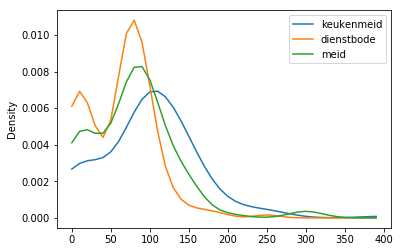

In [132]:
doc.plot.kde(ind=list(range(0,400,10)))